In [7]:
!pip install -q segment-geospatial
# also requires:
# apt-get update | apt-get install libgl1-mesa-glx
# until we rebuild into docker image


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [13]:
#!pip install -q rioxarray


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import rioxarray

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [11]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.5,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 1,
    "min_mask_region_area": 200,
}

In [12]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [13]:
image = '/home/data/kenya/images/kenol1_1867.tif'
mask = '/home/data/kenya/labels/kenol1_1867.tif'
example_image = rioxarray.open_rasterio(image)

example_groundtruth = rioxarray.open_rasterio(mask)

In [14]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

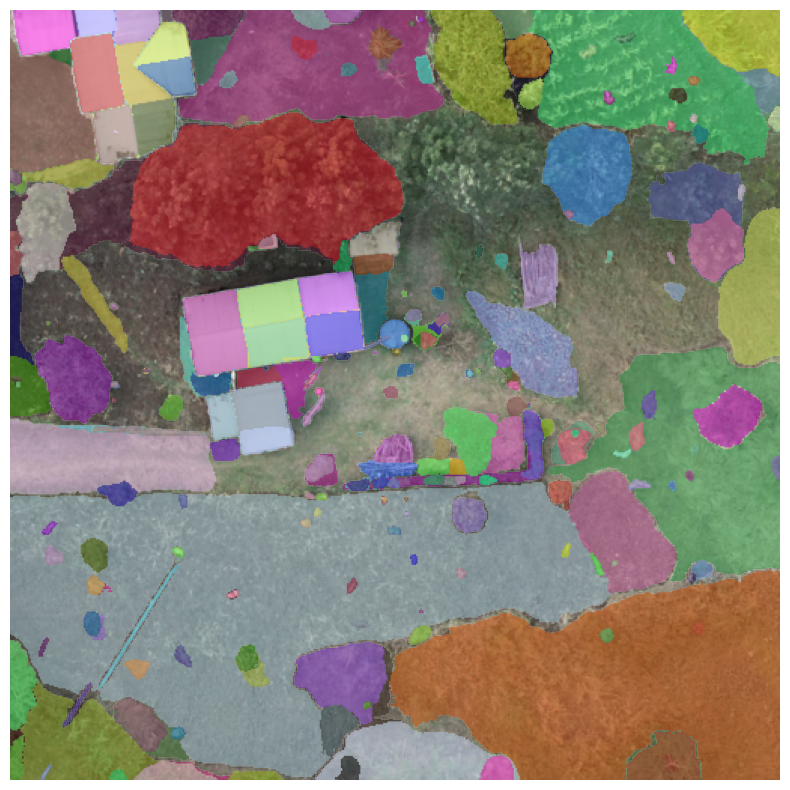

In [15]:
sam.show_anns(axis="off", alpha=0.5, output="annotations.tif")

In [16]:
object_segmentation = rioxarray.open_rasterio('masks.tif').to_numpy()
semantic_segmentation = rioxarray.open_rasterio(mask).to_numpy()

In [17]:
# Find unique object IDs
unique_objects = np.unique(object_segmentation)

In [18]:
print(unique_objects)

[  0   2   3   5   9  13  18  23  24  29  32  35  37  39  42  43  44  45
  48  52  54  57  61  62  63  70  72  73  76  80  84  85  86  89  90  96
  98 103 105 106 107 115 116 119 121 122 123 129 130 131 133 134 135 136
 141 144 145 147 149 150 154 155 158 160 161 162 163 164 165 168 169 174
 175 176 177 178 179 180 181 186 188 189 190 191 193 194 195 196 198 200
 202 203 205 206 208 209 210 211 212 213 214 216 223 224 226 227 228 229
 230 231 232 233 234 235 237 238 239 240 241 242 244 245 246 249 250 251
 252 253 254 255 256 257 258 259 260 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276]


In [19]:
new_segmentation = np.zeros_like(semantic_segmentation)

In [20]:
for obj_id in unique_objects:
  # Get pixels belonging to this object
  object_pixels = object_segmentation == obj_id
  # Count class occurrences within the object (excluding background class 0)
  class_counts = np.bincount(semantic_segmentation[object_pixels])
  # Assign majority class to object pixels (avoiding +1 as indexing starts from 0)
  new_segmentation = np.where(object_segmentation==obj_id, np.argmax(class_counts), new_segmentation)

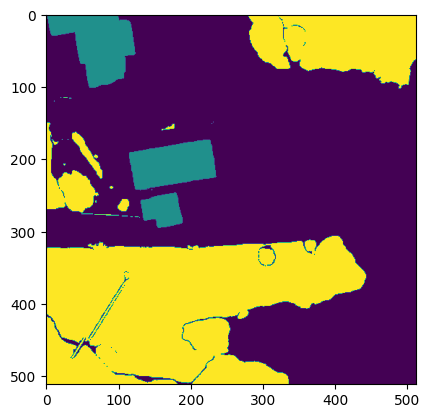

In [21]:
plt.imshow(new_segmentation[0,:,:])

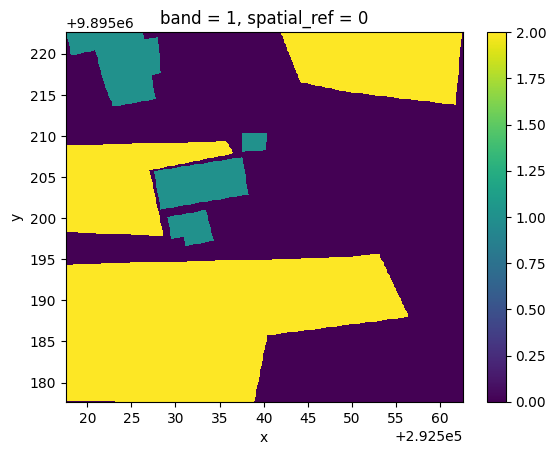

In [22]:
example_groundtruth.plot()

In [16]:
image_directory = "/home/data/kenya/images"
sam_mask_directory = "/home/data/kenya/sam_masks"
geoTIFF_files = [f for f in os.listdir(image_directory) if f.endswith('.tif')]

In [17]:
for filename in tqdm(geoTIFF_files, desc="generating SAM masks"):
    if filename.endswith(".tif"):
        filepath = os.path.join(image_directory, filename)
        output = os.path.join(sam_mask_directory, filename)
        sam.generate(filepath, output=output, foreground=True, unique=True)

generating SAM masks: 100%|███████████████████████████████████████████████████████| 2041/2041 [2:01:19<00:00,  3.57s/it]
